In [182]:
from gurobipy import *
import pandas as pd
import numpy as np
import networkx as NX
import matplotlib.pyplot as P 
%matplotlib inline

In [183]:
def weber(I,x,y,w):
    """weber: model for solving the single source weber problem using soco.
    Parameters:
        - I: set of customers
        - x[i]: x position of customer i
        - y[i]: y position of customer i
        - w[i]: weight of customer i
    Returns a model, ready to be solved.
    """

    model = Model("weber")
    X,Y,z,xaux,yaux = {},{},{},{},{}
    X = model.addVar(lb=-GRB.INFINITY, vtype="C", name="X")
    Y = model.addVar(lb=-GRB.INFINITY, vtype="C", name="Y")
    for i in I:
        z[i] = model.addVar(vtype="C", name="z(%s)"%(i))    
        xaux[i] = model.addVar(lb=-GRB.INFINITY, vtype="C", name="xaux(%s)"%(i))
        yaux[i] = model.addVar(lb=-GRB.INFINITY, vtype="C", name="yaux(%s)"%(i))    
    model.update()
    
    for i in I:
        model.addConstr(xaux[i]*xaux[i] + yaux[i]*yaux[i] <= z[i]*z[i], "MinDist(%s)"%(i))
        model.addConstr(xaux[i] == (x[i]-X), "xAux(%s)"%(i))
        model.addConstr(yaux[i] == (y[i]-Y), "yAux(%s)"%(i))

    model.setObjective(quicksum(w[i]*z[i] for i in I), GRB.MINIMIZE)

    model.update()
    model.__data = X,Y,z
    return model


In [184]:
ID = ['BO','PR','SP']
City = ['Boston','Providence','Springfield']
x = [100,86,20]
y = [80,40,60]
w = [425,320,220]
I = range(0,len(df['ID']))
model = weber(I,x,y,w)
model.optimize()
X,Y,z = model.__data
print("Optimal value=",model.ObjVal)
print("Selected position:")
print("\t",(round(X.X),round(Y.X)))
print("Solution:")
print("%s\t%8s" % ("i","z[i]"))
for i in I:
    print ("%s\t%8g" % (i,z[i].X))

Optimize a model with 6 rows, 11 columns and 12 nonzeros
Model has 3 quadratic constraints
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  QMatrix range    [1e+00, 1e+00]
  Objective range  [2e+02, 4e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e+01, 1e+02]
Presolve removed 2 rows and 2 columns
Presolve time: 0.01s
Presolved: 4 rows, 9 columns, 8 nonzeros
Presolved model has 3 second-order cone constraints
Ordering time: 0.00s

Barrier statistics:
 AA' NZ     : 6.000e+00
 Factor NZ  : 1.000e+01
 Factor Ops : 3.000e+01 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   9.51459497e+04  0.00000000e+00  0.00e+00 0.00e+00  1.06e+04     0s
   1   3.38111155e+04  2.26265735e+04  4.26e-14 9.66e-13  1.24e+03     0s
   2   3.18480063e+04  3.06264909e+04  3.41e-13 1.76e-12  1.36e+02     0s
   3   3.12412549e+04  3.11549560e+04  7.06e-12 2

In [271]:
df = pd.DataFrame({'ID':ID,'City Name':City,'Weight':Wgt,'xk':x,'yk':y})
df['DistW']=np.sqrt((X.X-df['xk'])**2+(Y.X-df['yk'])**2)
df['Wgt DistW']=df['DistW']*df['Weight']

df['xWeighted Coords'] = df['Weight']*df['xk']/(df['Weight'].sum())
df['yWeighted Coords'] = df['Weight']*df['yk']/(df['Weight'].sum())
xc = df['xWeighted Coords'].sum()
yc = df['yWeighted Coords'].sum()
df['DistC']=np.sqrt((xc-df['xk'])**2+(yc-df['yk'])**2)
df['Wgt DistC']=df['DistC']*df['Weight']
print('Centroid Coordinates: '+ str(np.round((xc,yc))))
print('Weber Coordinates: '+str(np.round((X.X,Y.X))))



WAD = (df['Wgt DistW']/(df['Weight'].sum())).sum()
CAD= (df['Wgt DistC']/(df['Weight'].sum())).sum()
print(WAD,CAD)

Centroid Coordinates: [77. 62.]
Weber Coordinates: [89. 66.]
32.30935725415357 33.72664912558155


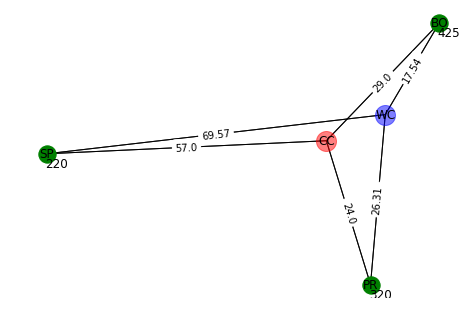

In [280]:
P.clf
G = NX.Graph()
pos=NX.spring_layout(G)
G.add_nodes_from(ID,weight={})
G.add_nodes_from(["WC"])
G.add_nodes_from(["CC"])
position = {}
weight = {}
for i in range(len(ID)):
    position[ID[i]] = (x[i],y[i])
    G.node[ID[i]]['weight']=w[i]
position["WC"] = (round(X.X),round(Y.X))
position["CC"] = (round(xc),round(yc))

for i in I:
    G.add_edge(ID[i], 'WC',length=np.round(z[i].X,2))
    G.add_edge(ID[i], 'CC',length=np.round(np.sqrt((xc-x[i])**2+(yc-y[i])**2)))
    
NX.draw(G,pos=position,node_size=300,node_color="g",nodelist=ID,with_labels=True)
NX.draw(G,pos=position,node_size=400,node_color="b",nodelist=["WC"],alpha=0.5)
NX.draw(G,pos=position,node_size=400,node_color="r",nodelist=["CC"],alpha=0.5)
pos_higher = {}
x_off = 2 # offset on the y axis
y_off = -1.5
for k, v in position.items():
    pos_higher[k] = (v[0]+x_off, v[1]+y_off)

edge_labels = NX.get_edge_attributes(G,'length')
node_labels = NX.get_node_attributes(G,'weight')
NX.draw_networkx_edge_labels(G,position,edge_labels=edge_labels)
NX.draw_networkx_labels(G,fontsize=200,pos=pos_higher,labels=node_labels)
P.savefig("weber.pdf",format="pdf",dpi=300)

P.show()


In [279]:
print(G.nodes(data=True))
print(G.edges(data=True))

[('BO', {'weight': 425}), ('PR', {'weight': 320}), ('SP', {'weight': 220}), ('WC', {}), ('CC', {})]
[('BO', 'WC', {'length': 17.54}), ('BO', 'CC', {'length': 29.0}), ('PR', 'WC', {'length': 26.31}), ('PR', 'CC', {'length': 24.0}), ('SP', 'WC', {'length': 69.57}), ('SP', 'CC', {'length': 57.0})]


Centroid Coordinates: [77. 62.]
